<a href="https://colab.research.google.com/github/kingiraffe/project/blob/master/model_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import datetime
import calendar
from folium.plugins import TimestampedGeoJson, HeatMapWithTime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [0]:
# load citibike data and preprocess datetime
citibike_07_519 = pd.read_csv('citibike_07_519.csv')
citibike_07_519 = citibike_07_519.drop(columns=['Unnamed: 0'], axis=1)

citibike_07_519['starttime'] = citibike_07_519['starttime'].str[:-5]
citibike_07_519['stoptime'] = citibike_07_519['stoptime'].str[:-5]
citibike_07_519['starttime'] = pd.to_datetime(citibike_07_519['starttime'])
citibike_07_519['stoptime'] = pd.to_datetime(citibike_07_519['stoptime'])

citibike_07_519 = citibike_07_519.set_index('starttime', drop=True)

# extract date from starttime
day_list = list(set(citibike_07_519.index.date))
day_list.sort()

# combine date and time
time_index = []
for day in day_list:
    for hour in range(0,24):
        time_index.append(datetime.datetime.combine(day, datetime.time(hour)))

# extract weekday from time_index
time_text = [x.date() for x in time_index]
weekday_text = [calendar.day_name[y.weekday()] for y in time_text]

# create list to store demand hour by hour
df_hour = []
for day in day_list:
    for hour in range(0,24):
        citibike_07_519_day = citibike_07_519.loc[citibike_07_519.index.date == day, ['start station latitude', 'start station longitude']]
        citibike_07_519_demand = citibike_07_519_day.loc[citibike_07_519_day.index.hour == hour]
        df_hour.append(citibike_07_519_demand.shape[0])

# load regression, gbtr, rf result
df_reg = pd.read_csv('df_regression.csv')
reg_pre = df_reg['prediction']
df_gbtr = pd.read_csv('df_gbtr.csv')
gbtr_pre = df_gbtr['prediction']
df_rf = pd.read_csv('df_rf.csv')
rf_pre = df_rf['prediction']

In [0]:
df_reg

,Unnamed: 0,SPD,GUS,CLR,SCT,BKN,OVC,OBS,POB,VSB,TEMP,DEWP,SLP,ALT,STP,PCP01,hour,weekday_end,count,va_features,prediction
0,0,-1.128286,-0.304548,1,0,0,0,0,0,0.463861,0.184085,0.069394,-0.411392,-0.400542,-0.402984,-0.178119,0,0,2,"(17,[0,1,2,8,9,10,11,12,13,14],[-1.12828554137...",1.555556
1,1,-0.204597,-0.304548,1,0,0,0,0,0,0.463861,0.101782,0.142199,-0.349287,-0.347805,-0.340400,-0.178119,1,0,1,"[-0.2045971821636372,-0.3045476160907193,1.0,0...",0.506173
2,2,0.719091,-0.304548,1,0,0,0,0,0,0.463861,0.019478,0.142199,-0.287182,-0.295068,-0.293462,-0.178119,2,0,1,"[0.7190911770434785,-0.3045476160907193,1.0,0....",0.506173
3,3,-1.128286,-0.304548,1,0,0,0,0,0,0.463861,0.019478,0.069394,-0.256129,-0.242331,-0.246525,-0.178119,3,0,0,"[-1.1282855413707529,-0.3045476160907193,1.0,0...",0.506173
4,4,-0.204597,-0.304548,1,0,0,0,0,0,0.463861,-0.062825,0.069394,-0.240603,-0.242331,-0.246525,-0.178119,4,0,1,"[-0.2045971821636372,-0.3045476160907193,1.0,0...",0.506173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,727,-0.204597,-0.304548,1,0,0,0,0,0,0.097945,0.924817,1.161473,0.302814,0.337777,0.332374,-0.178119,7,0,61,"[-0.2045971821636372,-0.3045476160907193,1.0,0...",52.975124
728,728,-1.128286,-0.304548,1,0,0,0,0,0,-0.349287,1.089425,1.161473,0.333867,0.337777,0.332374,-0.178119,8,0,103,"[-1.1282855413707529,-0.3045476160907193,1.0,0...",52.975124
729,729,-1.128286,-0.304548,1,0,0,0,0,0,-0.349287,1.171728,1.161473,0.333867,0.337777,0.332374,-0.178119,9,0,64,"[-1.1282855413707529,-0.3045476160907193,1.0,0...",52.975124
730,730,-0.204597,-0.304548,1,0,0,0,0,0,-0.349287,1.418639,1.161473,0.380445,0.390514,0.394957,-0.178119,10,0,20,"[-0.2045971821636372,-0.3045476160907193,1.0,0...",16.507326


In [0]:
# load weather data
weather_data = pd.read_csv('original_weather.csv')

# extract weather data hour by hour
weather_data['starttime'] = pd.to_datetime(weather_data['starttime'])
weather_data.set_index('starttime', inplace=True)
weather_data_5 = weather_data[weather_data.index.month == 5]

# extract temperature and wind speed data
temp_data = weather_data_5['TEMP']
speed_data = weather_data_5['SPD']

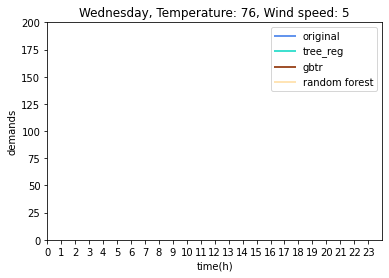

In [0]:
# create animation of original demands and predicted ones
fig, ax = plt.subplots()
ax.set_xlim(0, 24)
ax.set_ylim(0, 200)
ax.set_xticks(range(0, 24))
ax.set_xlabel('time(h)')
ax.set_ylabel('demands')
line, = ax.plot([], [])

plotlays, plotcols, labels = [4], ["cornflowerblue", "turquoise", "sienna", "moccasin"], ["original", "tree_reg", "gbtr", "random forest"]
lines = []
for index in range(4):
  lobj = ax.plot([], [], color=plotcols[index], label=labels[index], linewidth=2)[0]
  ax.legend(loc='upper right')
  lines.append(lobj)

def init():
  for line in lines:
    line.set_data([], [])
  return lines

x_data = [0] * 24
y_data = [0] * 24

x_data2 = [0] * 24
y_data2 = [0] * 24

x_data3 = [0] * 24
y_data3 = [0] * 24

x_data4 = [0] * 24
y_data4 = [0] * 24

def animate(i):
  x_data[i%24] = i%24
  y_data[i%24] = df_hour[i]

  x_data2[i%24] = i%24
  y_data2[i%24] = reg_pre[i]

  x_data3[i%24] = i%24
  y_data3[i%24] = gbtr_pre[i]

  x_data4[i%24] = i%24
  y_data4[i%24] = rf_pre[i]

  xlist = [x_data, x_data2, x_data3, x_data4]
  ylist = [y_data, y_data2, y_data3, y_data4]

  ax.set_title("{}, Temperature: {}, Wind speed: {}".format(weekday_text[i], temp_data[i], speed_data[i]))

  for lnum, line in enumerate(lines):
    line.set_data(xlist[lnum], ylist[lnum])
  return lines

animation = FuncAnimation(fig, animate, init_func=init, frames=np.arange(0, 732, 1), interval=150)
HTML(animation.to_html5_video())

In [0]:
from PIL import Image

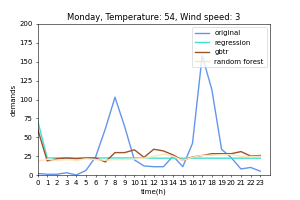

In [0]:
from numpngw import AnimatedPNGWriter
writer = AnimatedPNGWriter(fps=2)
animation.save('prediction.png', dpi=50, writer=writer)

In [0]:
from pyspark import SparkContext, SQLContext
from pyspark.sql import functions as F

In [0]:
# set up pyspark stream
sc = SparkContext("local", "bycicle")
sqlContext = SQLContext(sc)

In [0]:
# load citibike data
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('201904-citibike-tripdata.csv')
df5 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('201905-citibike-tripdata.csv')
df6 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('201906-citibike-tripdata.csv')
df7 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('201907-citibike-tripdata.csv')
df.union(df5)
df.union(df6)
df.union(df7)

In [0]:
df7.show()

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|tripduration|           starttime|            stoptime|start station id|  start station name|start station latitude|start station longitude|end station id|    end station name|end station latitude|end station longitude|bikeid|  usertype|birth year|gender|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|         897|2019-07-01 00:00:...|2019-07-01 00:14:...|             493|     W 45 St & 6 Ave|            40.7568001|           -73.98291153|           454|     E 51 St & 1 Ave|         40.75455731|         -73.96592976| 18340|Su

In [0]:
# extract data of station 519
df7 = df7.filter(df7['start station id']==519)

In [0]:
df7.show()

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|tripduration|           starttime|            stoptime|start station id|  start station name|start station latitude|start station longitude|end station id|    end station name|end station latitude|end station longitude|bikeid|  usertype|birth year|gender|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+----------+----------+------+
|         382|2019-07-01 00:24:...|2019-07-01 00:30:...|             519|Pershing Square N...|             40.751873|             -73.977706|           478|    11 Ave & W 41 St|         40.76030096|         -73.99884222| 39247|Su

In [0]:
# set time window
hour_window = F.window(F.col("starttime"), "1 hour", "1 hour").start.alias("starttime")

In [0]:
# group by time window
hour_num = df7.groupBy(hour_window).count()

In [0]:
hour_num.show()

+-------------------+-----+
|          starttime|count|
+-------------------+-----+
|2019-07-03 21:00:00|    7|
|2019-07-15 12:00:00|   11|
|2019-07-18 14:00:00|   30|
|2019-07-09 10:00:00|   13|
|2019-07-11 12:00:00|   14|
|2019-07-04 16:00:00|   19|
|2019-07-13 22:00:00|   14|
|2019-07-16 00:00:00|    1|
|2019-07-23 01:00:00|    1|
|2019-07-03 03:00:00|    1|
|2019-07-21 12:00:00|   16|
|2019-07-04 09:00:00|    5|
|2019-07-12 01:00:00|    1|
|2019-07-20 18:00:00|   10|
|2019-07-03 17:00:00|   93|
|2019-07-07 17:00:00|   20|
|2019-07-20 15:00:00|   15|
|2019-07-02 01:00:00|    3|
|2019-07-13 17:00:00|   23|
|2019-07-14 01:00:00|    3|
+-------------------+-----+
only showing top 20 rows



In [0]:
hour_num['starttime']